### Setup

In [1]:
# Main
import numpy as np
import scipy as sp
import pandas as pd
import datetime as dt
from statsmodels.tsa.tsatools import lagmat

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.tsatools import add_trend

# Unit root
from arch.unitroot import ADF, DFGLS, PhillipsPerron, KPSS, ZivotAndrews
from quantileADF import QAR, comparisonPlot
from quantileTAR import QTAR, QTAR_CustomRport
from report import countryReport, reportCountries

# Tests and function
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.stats.stattools import jarque_bera
from statsmodels.regression.linear_model import OLS

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Setup
repoUrl = 'https://raw.githubusercontent.com/vlad-yeghiazaryan/QADF/master/data/'
broadREERsUrl = repoUrl + 'broadREERs.csv'
narrowREERsUrl = repoUrl + 'narrowREERs.csv'
pd.io.formats.excel.ExcelFormatter.header_style = None

In [2]:
def univariate(data):
    univariateTests = pd.DataFrame()
    univariateTests['ADF'] = data.apply(lambda col: ADF(col).pvalue)
    univariateTests['DFGLS'] = data.apply(lambda col: DFGLS(col).pvalue)
    univariateTests['PP'] = data.apply(lambda col: PhillipsPerron(col).pvalue)
    univariateTests['KPSS'] = data.apply(lambda col: KPSS(col).pvalue)
    univariateTests['ZA'] = data.apply(lambda col: ZivotAndrews(col).pvalue)
    return univariateTests.applymap(lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)

In [3]:
def comparisonPlots(data,fileName='changesOverQuantiles'):
    figs = []
    for index, pos in enumerate(range(0, data.shape[1], 3)):
        columns = data.columns[pos: min(data.shape[1], pos+3)]
        figsize = (len(columns)*5, 6)
        countries = data[columns]
        fig = comparisonPlot(countries, figsize=figsize)
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{index+1}', dpi = 150)
    return figs

In [4]:
def markovRegimeSwitchingPlots(data, fileName='regimeSwitchingProbabilities'):
    figs = []
    for i, pos in enumerate(range(0, data.shape[1], 2)):
        columns = data.columns[pos: min(data.shape[1], pos+2)]
        figsize = (len(columns)*5, 6)
        fig = plt.figure()
        for index, country in enumerate(columns):
            mainModel = QAR(data[country])
            ax = fig.add_subplot(1, len(columns), index+1)
            mod = sma.tsa.MarkovRegression(mainModel.y, trend='c', k_regimes=2, order=2, freq='MS').fit()
            ylabel = 'Probability of being in the high regime'
            title = mainModel.name
            ax = mod.smoothed_marginal_probabilities[1].plot(title=title,ylabel=ylabel, figsize=(12,3))
            ax.axvline('2015-1-1', color='black')
            trans = ax.get_xaxis_transform()
            plt.text('2015-1-1', -.1, 'EAEU', transform=trans, weight='bold')
            ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        figs.append(fig)
        plt.savefig(f'Outputs/{fileName}-{i+1}', dpi = 150)
    return figs

In [5]:
def saveToExcel(dataframe, path, def_properties={}):
    # Setup
    writer = pd.ExcelWriter(path)
    dataframe.style.set_properties(**def_properties).to_excel(writer)

    def dummyCriteria(f): return {'type': 'cell',
                                  'criteria': '!=', 'value': 0, 'format': f}

    def excel_colnum_string(n):
        string = ""
        while n > 0:
            n, remainder = divmod(n - 1, 26)
            string = chr(65 + remainder) + string
        return string

    # Accessing
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    colLetter = excel_colnum_string(dataframe.shape[1]+1)
    tableRange = 'A1:'+colLetter+str(dataframe.shape[0]+1)
    header = 'A1:'+colLetter+'1'
    footer = 'A'+str(dataframe.shape[0]+1) + \
        ':'+colLetter+str(dataframe.shape[0]+1)
    indexCol = 'A1:'+'A'+str(dataframe.shape[0]+1)

    # Styles
    defaultFormat = {'font_name': 'Calibri', 'font_size': 8,
                     'bg_color': '#FFFFFF',
                     'align': 'center',
                     'valign': 'vcenter',
                     'border': 0,
                     'shrink': True,
                     'text_wrap': True}
    columnFormat = workbook.add_format(defaultFormat)
    columnFormat.set_font_size(8)
    headerFormat = workbook.add_format(
        {**defaultFormat, **{'top': 5, 'bottom': 2, 'bold': True}})
    footerFormat = workbook.add_format({**defaultFormat, **{'bottom': 5}})
    indexFormat = workbook.add_format({**defaultFormat, **{'align': 'left'}})

    # Applying Styles
    worksheet.conditional_format(tableRange, dummyCriteria(columnFormat))
    worksheet.conditional_format(header, dummyCriteria(headerFormat))
    worksheet.conditional_format(footer, dummyCriteria(footerFormat))
    worksheet.conditional_format(indexCol, dummyCriteria(indexFormat))
    writer.save()
    print('Table saved to:', path)

In [6]:
data = pd.read_pickle('data/dataset2000.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-01 to 2020-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Armenia             252 non-null    float64
 1   Belarus             252 non-null    float64
 2   Kazakhstan          252 non-null    float64
 3   Kyrgyz Republic     252 non-null    float64
 4   Russian Federation  252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


In [7]:
# Changing data
dataLogs = data.apply(np.log, axis=1)
dataPtC = dataLogs.diff()[1:]

### REERs of EAEU countries

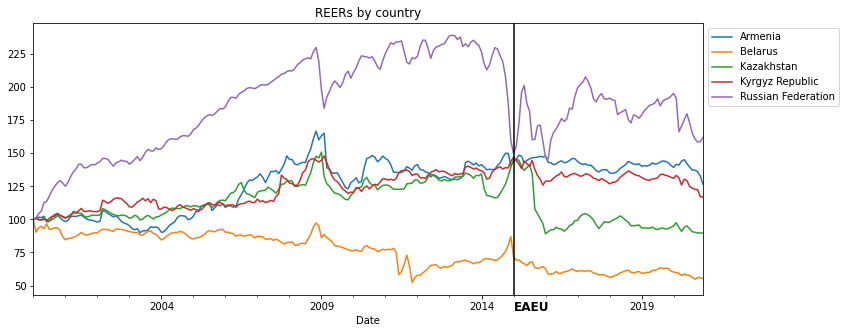

In [8]:
ax = data.plot(kind='line', subplots=False, sharey=True, 
          layout=(1,1), figsize=(12, 5), title='REERs by country', legend=False)

ax.legend(bbox_to_anchor=(1, 1), loc='best')
mark = '2015'
ax.axvline(mark+'-1-1', color='black')
ax.text(mark+'-1-1', -0.06, 'EAEU', transform=ax.get_xaxis_transform(), weight='bold', fontsize='large')

# plt.savefig('Outputs/REERsByCountry', dpi = 150, bbox_inches='tight')
plt.show()

In [9]:
colNames = {
    'count': 'N',
    'mean': 'Mean',
    'std': 'St.dev.',
    'min': 'Min.',
    'max': 'Max.',
    '50%': 'Median',
}
tests = ['Jarque-Bera', 'Jarque-Bera (P-value)', 'Skewness', 'Kurtosis']
include = ['N', 'Mean', 'Median', 'Min.', 'Max.', 'St.dev.',
           'Skewness', 'Kurtosis', 'Jarque-Bera', 'Jarque-Bera (P-value)']

# Summary Setup
summaryStatistics = data.describe().T
JB = data.apply(jarque_bera).T
summaryStatistics[tests] = JB
summaryStatistics.rename(columns=colNames, inplace=True)
summaryTable = summaryStatistics[include].applymap(
    lambda x: '%.0f' % x if x.is_integer() else '%.3f' % x)
summaryTable.index.name = 'Countries'
# saveToExcel(summaryTable, path="Outputs/summaryStatistics.xlsx", def_properties={'text-align': 'center'})
summaryTable

,N,Mean,Median,Min.,Max.,St.dev.,Skewness,Kurtosis,Jarque-Bera,Jarque-Bera (P-value)
Countries,,,,,,,,,,
Armenia,252,127.879,135.958,89.885,166.704,19.159,-0.587,1.975,25.519,0.000
Belarus,252,75.912,77.463,52.366,100,13.029,-0.108,1.463,25.287,0.000
Kazakhstan,252,112.865,110.283,89.110,150.867,14.969,0.286,1.981,14.343,0.001
Kyrgyz Republic,252,124.187,128.753,99.346,147.947,12.583,-0.278,1.844,17.271,0.000
Russian Federation,252,186.077,189.731,100,239.097,33.296,-0.342,2.300,10.048,0.007


In [10]:
univariateTable = univariate(dataLogs)
univariateTable.index.name = 'Countries'
# saveToExcel(univariateTable, path='Outputs/univariateTests.xlsx')
univariateTable

,ADF,DFGLS,PP,KPSS,ZA
Countries,,,,,
Armenia,0.431,0.422,0.465,0.000,0.135
Belarus,0.822,0.865,0.676,0.000,0.157
Kazakhstan,0.329,0.097,0.611,0.033,0.000
Kyrgyz Republic,0.208,0.423,0.225,0.000,0.386
Russian Federation,0.028,0.627,0.022,0.003,0.279


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:460: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  lags = lags.drop(x_columns, 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:460: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  lags = lags.drop(x_columns, 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:460: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  lags = lags.drop(x_columns, 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:4

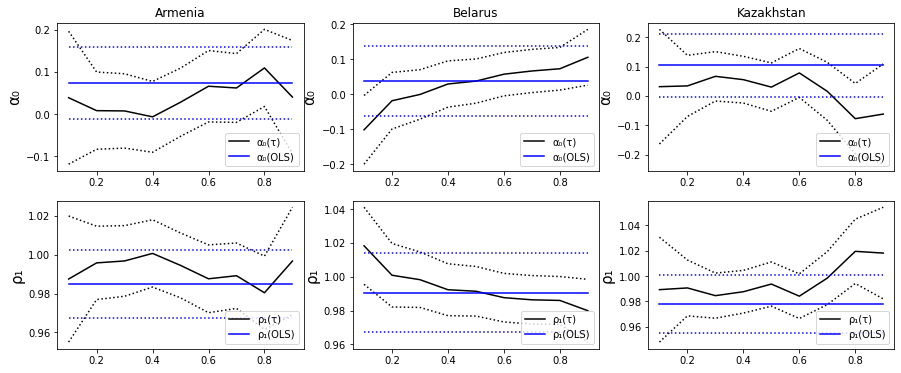

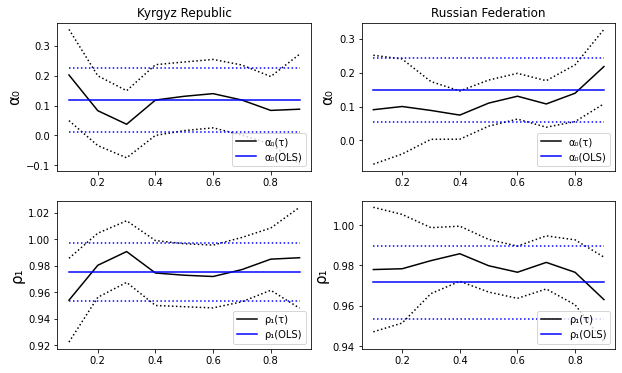

In [11]:
comparisonPlots(dataLogs)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:460: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  lags = lags.drop(x_columns, 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:460: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  lags = lags.drop(x_columns, 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:460: FutureWarni

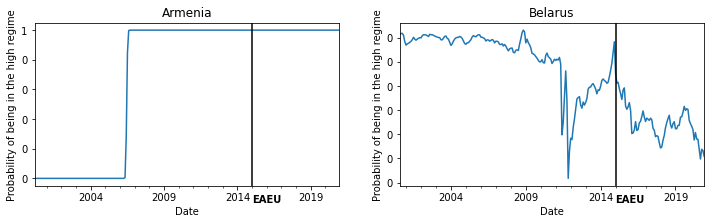

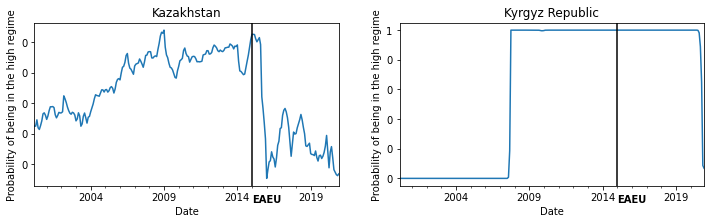

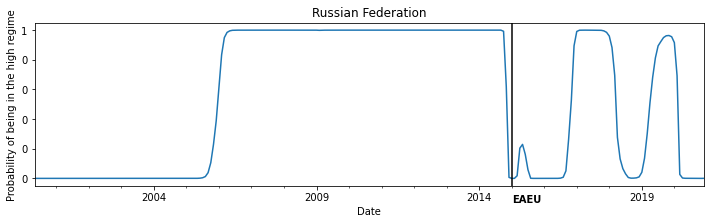

In [12]:
markovRegimeSwitchingPlots(data)
plt.show()

## Covergence in subsamples

In [13]:
countries = dataLogs.columns

In [14]:
def add_Stars(b,se,lags):
    tstat = pd.DataFrame((b-1)/se)
    pval = tstat.applymap(lambda x: sm.tsa.adfvalues.mackinnonp(x,regression='c',N=1,lags=lags))
    stars = pval.applymap(lambda x: '***' if x <= 0.01 else '**' if x <= 0.05 else '*' if x <= 0.1 else '')
    table = pd.DataFrame(b).round(2).astype(str) + stars
    return table

In [15]:
def createTable(results,modelname,coeffnames,lags):
    idx = pd.MultiIndex.from_product([modelname,coeffnames],names=('model','coef'))
    table = pd.DataFrame(index=idx)
    for c, country in enumerate(countries):
        cell = add_Stars(results[c].params[coeffnames]+1,results[c].bse[coeffnames],lags)
        table = table.join(pd.DataFrame(cell.values,index=idx,columns=[country]))
    return table

### Optimal lag length

#### ADF test with constant

In [16]:
# ADF test with constant
ADF_aic_ct = np.full((len(countries),12),np.nan)
ADF_bic_ct = np.full((len(countries),12),np.nan)
for ic,country in enumerate(countries):
    diff = dataLogs[country].diff(1)
    for l in range(1,12+1):
        d_y = diff[1+l:]
        y_1 = dataLogs[country].shift(1).rename('Level.L1')
        d_y_lags = pd.DataFrame(lagmat(diff, maxlag=l), index=diff.index,
                                columns=['Diff.L'+str(i) for i in range(1, l+1)])
        X = sma.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+l:]
        res = OLS(d_y, exog=X).fit()
        ADF_aic_ct[ic,l-1] = res.aic
        ADF_bic_ct[ic,l-1] = res.bic

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [17]:
ADF_aic_ct_df = pd.DataFrame(data=ADF_aic_ct,index=countries,columns=range(1,12+1))
ADF_bic_ct_df = pd.DataFrame(data=ADF_bic_ct,index=countries,columns=range(1,12+1))

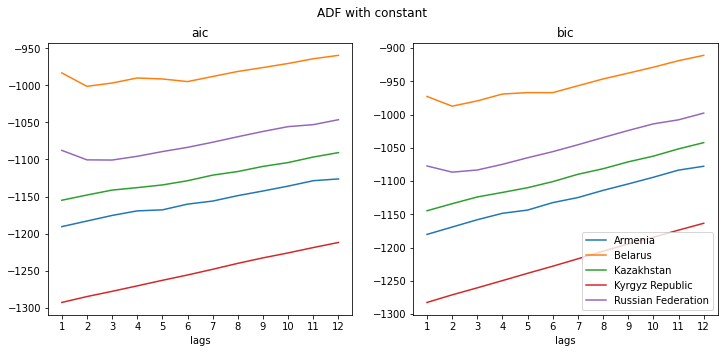

In [18]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
for country in countries:
    axes[0].plot(range(1,12+1),ADF_aic_ct_df.loc[country,:], label=country)
    axes[1].plot(range(1,12+1),ADF_bic_ct_df.loc[country,:], label=country)
axes[0].set_xlabel('lags')
axes[1].set_xlabel('lags')
axes[0].set_xticks(range(1,12+1))
axes[1].set_xticks(range(1,12+1))
axes[0].set_title('aic')
axes[1].set_title('bic')
axes[1].legend()
fig.suptitle('ADF with constant');

#### ADF test with trend

In [19]:
# ADF test with trend
ADF_aic_tr = np.full((len(countries),12),np.nan)
ADF_bic_tr = np.full((len(countries),12),np.nan)
for ic,country in enumerate(countries):
    diff = dataLogs[country].diff(1)
    for l in range(1,12+1):
        d_y = diff[1+l:]
        y_1 = dataLogs[country].shift(1).rename('Level.L1')
        d_y_lags = pd.DataFrame(lagmat(diff, maxlag=l), index=diff.index,
                                columns=['Diff.L'+str(i) for i in range(1, l+1)])
        X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+l:]
        res = OLS(d_y, exog=X).fit()
        ADF_aic_tr[ic,l-1] = res.aic
        ADF_bic_tr[ic,l-1] = res.bic

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
ADF_aic_tr_df = pd.DataFrame(data=ADF_aic_tr,index=countries,columns=range(1,12+1))
ADF_bic_tr_df = pd.DataFrame(data=ADF_bic_tr,index=countries,columns=range(1,12+1))

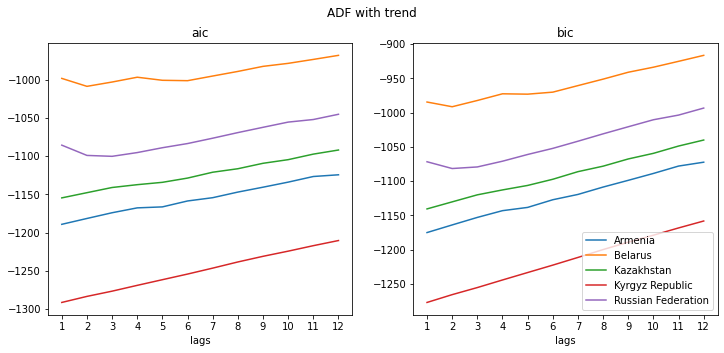

In [21]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
for country in countries:
    axes[0].plot(range(1,12+1),ADF_aic_tr_df.loc[country,:], label=country)
    axes[1].plot(range(1,12+1),ADF_bic_tr_df.loc[country,:], label=country)
axes[0].set_xlabel('lags')
axes[1].set_xlabel('lags')
axes[0].set_xticks(range(1,12+1))
axes[1].set_xticks(range(1,12+1))
axes[0].set_title('aic')
axes[1].set_title('bic')
axes[1].legend()
fig.suptitle('ADF with trend');

### Set lags

In [22]:
lags = 2

### Unit root tests the whole sample

#### ADF test with constant

In [23]:
# ADF test with constant
ADF_res_ct = []
for country in countries:
    diff = dataLogs[country].diff(1)
    d_y = diff[1+lags:]
    y_1 = dataLogs[country].shift(1).rename('Level.L1')
    d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                            columns=['Diff.L'+str(i) for i in range(1, lags+1)])
    X = sma.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
    res = OLS(d_y, exog=X).fit()
    ADF_res_ct.append(res)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
table_ct = createTable(ADF_res_ct,['all'],['Level.L1'],lags)
table_ct

,,Armenia,Belarus,Kazakhstan,Kyrgyz Republic,Russian Federation
model,coef,,,,,
all,Level.L1,0.99,0.99,0.98,0.97,0.97**


#### ADF with trend

In [25]:
# ADF test with trend
ADF_res_tr = []
for country in countries:
    diff = dataLogs[country].diff(1)
    d_y = diff[1+lags:]
    y_1 = dataLogs[country].shift(1).rename('Level.L1')
    d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                            columns=['Diff.L'+str(i) for i in range(1, lags+1)])
    X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+lags:]
    res = OLS(d_y, exog=X).fit()
    ADF_res_tr.append(res)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
table_tr = createTable(ADF_res_tr,['all'],['Level.L1'],lags)
table_tr

,,Armenia,Belarus,Kazakhstan,Kyrgyz Republic,Russian Federation
model,coef,,,,,
all,Level.L1,0.98,0.9**,0.98,0.97,0.98


### Unit root tests for pre- and post-EAEU periods

#### ADF test with constant

##### ADF test with dummies

In [27]:
# ADF test with constant and pre- and post-EAEU dummies
ADF_res_pre_post_ct = []
for country in countries:
    diff = dataLogs[country].diff(1)
    d_y = diff[1+lags:]
    EAEU = (dataLogs.index > '2015-01-01').astype(int)
    y_1 = dataLogs[country].shift(1).rename('Level.L1')
    y_1_post = pd.DataFrame(y_1*EAEU).add_suffix('_post')
    y_1_pre =  pd.DataFrame(y_1*(1-EAEU)).add_suffix('_pre')
    d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                            columns=['Diff.L'+str(i) for i in range(1, lags+1)])
    X = sma.add_constant(pd.concat([y_1_pre, y_1_post, d_y_lags], axis=1))[1+lags:]
    res = OLS(d_y, exog=X).fit()
    ADF_res_pre_post_ct.append(res)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
table_pre_post_ct = createTable(ADF_res_pre_post_ct,['pre-post'],['Level.L1_pre','Level.L1_post'],lags)
table_pre_post_ct

Armenia Belarus Kazakhstan Kyrgyz Republic  \
model    coef                                                       
pre-post Level.L1_pre     0.99    0.96    0.95***            0.98   
         Level.L1_post    0.99    0.96    0.95***            0.98   

                       Russian Federation  
model    coef                              
pre-post Level.L1_pre              0.97**  
         Level.L1_post             0.97**

In [29]:
# # ADF test with post-EAEU dummy (Level.L1_post: beta_1 - beta_2 version)
# X = sma.add_constant(pd.concat([y_1, y_1_post, d_y_lags], axis=1))[1+lags:]
# res = OLS(d_y, exog=X).fit()
# res.summary()

##### ADF test in subsmaples

In [30]:
# ADF test with constant in pre- and post-EAEU samples
ADF_res_pre_ct = []
ADF_res_post_ct = []
for country in countries:
    diff = dataLogs[country].diff(1)
    d_y = diff[1+lags:]
    y_1 = dataLogs[country].shift(1).rename('Level.L1')
    d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                            columns=['Diff.L'+str(i) for i in range(1, lags+1)])
    X = sma.add_constant(pd.concat([y_1, d_y_lags], axis=1))[1+lags:]
    # pre-EAEU
    res = OLS(d_y[:'2015-01-01'], exog=X[:'2015-01-01']).fit()
    ADF_res_pre_ct.append(res)
    # post-EAEU
    res = OLS(d_y['2015-01-01':], exog=X['2015-01-01':]).fit()
    ADF_res_post_ct.append(res)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
table_pre_ct = createTable(ADF_res_pre_ct,['pre'],['Level.L1'],lags)
table_pre_ct

,,Armenia,Belarus,Kazakhstan,Kyrgyz Republic,Russian Federation
model,coef,,,,,
pre,Level.L1,0.99,0.97,0.98,0.98,0.98


In [32]:
table_post_ct = createTable(ADF_res_post_ct,['post'],['Level.L1'],lags)
table_post_ct

,,Armenia,Belarus,Kazakhstan,Kyrgyz Republic,Russian Federation
model,coef,,,,,
post,Level.L1,0.99,0.74***,0.93*,0.94,0.83*


#### ADF with trend

##### ADF test with dummies

In [33]:
# ADF test with trend and pre- and post-EAEU dummies
ADF_res_pre_post_tr = []
for country in countries:
    diff = dataLogs[country].diff(1)
    d_y = diff[1+lags:]
    EAEU = (dataLogs.index > '2015-01-01').astype(int)
    y_1 = dataLogs[country].shift(1).rename('Level.L1')
    y_1_post = pd.DataFrame(y_1*EAEU).add_suffix('_post')
    y_1_pre =  pd.DataFrame(y_1*(1-EAEU)).add_suffix('_pre')
    d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                            columns=['Diff.L'+str(i) for i in range(1, lags+1)])
    X = add_trend(pd.concat([y_1_pre, y_1_post, d_y_lags], axis=1), 'ct')[1+lags:]
    res = OLS(d_y, exog=X).fit()
    ADF_res_pre_post_tr.append(res)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [34]:
table_pre_post_tr = createTable(ADF_res_pre_post_tr,['pre-post'],['Level.L1_pre','Level.L1_post'],lags)
table_pre_post_tr

Armenia Belarus Kazakhstan Kyrgyz Republic  \
model    coef                                                       
pre-post Level.L1_pre     0.97   0.9**    0.93***           0.94*   
         Level.L1_post    0.97   0.9**    0.92***           0.94*   

                       Russian Federation  
model    coef                              
pre-post Level.L1_pre                0.98  
         Level.L1_post               0.98

##### ADF test in subsmaples

In [35]:
# ADF test with trend in pre- and post-EAEU samples
ADF_res_pre_tr = []
ADF_res_post_tr = []
for country in countries:
    diff = dataLogs[country].diff(1)
    d_y = diff[1+lags:]
    y_1 = dataLogs[country].shift(1).rename('Level.L1')
    d_y_lags = pd.DataFrame(lagmat(diff, maxlag=lags), index=diff.index,
                            columns=['Diff.L'+str(i) for i in range(1, lags+1)])
    X = add_trend(pd.concat([y_1, d_y_lags], axis=1), 'ct')[1+lags:]
    # pre-EAEU
    res = OLS(d_y[:'2015-01-01'], exog=X[:'2015-01-01']).fit()
    ADF_res_pre_tr.append(res)
    # post-EAEU
    res = OLS(d_y['2015-01-01':], exog=X['2015-01-01':]).fit()
    ADF_res_post_tr.append(res)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
table_pre_tr = createTable(ADF_res_pre_tr,['pre'],['Level.L1'],lags)
table_pre_tr

,,Armenia,Belarus,Kazakhstan,Kyrgyz Republic,Russian Federation
model,coef,,,,,
pre,Level.L1,0.96,0.9*,0.9***,0.91**,1.0


In [37]:
table_post_tr = createTable(ADF_res_post_tr,['post'],['Level.L1'],lags)
table_post_tr

,,Armenia,Belarus,Kazakhstan,Kyrgyz Republic,Russian Federation
model,coef,,,,,
post,Level.L1,0.89,0.7***,0.91,0.86,0.84


#### Summarizing results

##### ADF with constant

In [38]:
Table_ct = pd.concat((table_ct,table_pre_post_ct,table_pre_ct,table_post_ct)).transpose()
Table_ct.to_excel('./Outputs/OLS_ct.xlsx')
Table_ct

model                   all     pre-post                    pre     post
coef               Level.L1 Level.L1_pre Level.L1_post Level.L1 Level.L1
Armenia                0.99         0.99          0.99     0.99     0.99
Belarus                0.99         0.96          0.96     0.97  0.74***
Kazakhstan             0.98      0.95***       0.95***     0.98    0.93*
Kyrgyz Republic        0.97         0.98          0.98     0.98     0.94
Russian Federation   0.97**       0.97**        0.97**     0.98    0.83*

##### ADF with trend

In [39]:
Table_tr = pd.concat((table_tr,table_pre_post_tr,table_pre_tr,table_post_tr)).transpose()
Table_tr.to_excel('./Outputs/OLS_tr.xlsx')
Table_tr

model                   all     pre-post                    pre     post
coef               Level.L1 Level.L1_pre Level.L1_post Level.L1 Level.L1
Armenia                0.98         0.97          0.97     0.96     0.89
Belarus               0.9**        0.9**         0.9**     0.9*   0.7***
Kazakhstan             0.98      0.93***       0.92***   0.9***     0.91
Kyrgyz Republic        0.97        0.94*         0.94*   0.91**     0.86
Russian Federation     0.98         0.98          0.98      1.0     0.84

### Capturing Convergence

In [40]:
y = data['Belarus']
EAEU = pd.Series((y.index > '2014-12-01').astype(int), index=y.index, name='EAEU')
qtar_model = QTAR(y, EAEU, 'ct', pmax=12, ic='AIC')
res = qtar_model.fit(0.5)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
res.summary()

quantile: 0.5
Lags: 6
α₀(τ): 9.5236
ρ₁(τ): 0.8991
α₁(τ): -0.00537
δ²: 0.25
tₙ(τ): -4.8044


In [42]:
res.regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                Belarus   Pseudo R-squared:               0.8975
Model:                       QuantReg   Bandwidth:                      0.9092
Method:                 Least Squares   Sparsity:                        2.898
Date:                Wed, 25 Aug 2021   No. Observations:                  245
Time:                        23:03:00   Df Residuals:                      235
                                        Df Model:                            9
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.5236      2.035      4.679      0.000       5.514      13.534
Belarus.L1               0.8991      0.021     42.964      0.000       0.858       0.940
post-EAEU_Belarus.L1    -0.0054      0.005     -1.014      0.312      -0.016       0.005
Diff.L1                  0.1498      0.042      3.533      0.000       0.066       0.233
Diff.L2                 -0.0834      0.043     -1.960      0.051      -0.167       0.000
Diff.L3                  0.0301      0.043      0.703      0.483      -0.054       0.115
Diff.L4                  0.0061      0.043      0.143      0.886      -0.078       0.090
Diff.L5                  0.0214      0.041      0.525      0.600      -0.059       0.102
Diff.L6                 -0.1171      0.040     -2.936      0.004      -0.196      -0.039
trend                   -0.0151      0.004     -3.646      0.000      -0.023      -0.007
========================================================================================

The condition number is large, 3.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
quantiles = np.arange(0.1, 1, 0.1)
res.fitForQuantiles(quantiles)

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Lags,α₀(τ),ρ₁(τ),α₁(τ),δ²,tₙ(τ),QKS,name
quantile,,,,,,,,
0.1,6,8.9843,0.8866,-0.00558,0.316,-1.9050,5.1136,Belarus
0.2,6,10.4360,0.8808,-0.00913,0.276,-3.9013,5.1136,Belarus
0.3,6,9.2477,0.8984,-0.00075,0.277,-4.1011,5.1136,Belarus
0.4,6,9.2345,0.9014,-0.00266,0.261,-5.1136,5.1136,Belarus
0.5,6,9.5236,0.8991,-0.00537,0.250,-4.8044,5.1136,Belarus
0.6,6,7.8159,0.9187,-0.01188,0.245,-3.8647,5.1136,Belarus
0.7,6,7.3408,0.9257,-0.01976,0.231,-2.9234,5.1136,Belarus
0.8,6,4.7978,0.9537,-0.03072,0.200,-1.6762,5.1136,Belarus
0.9,6,5.1247,0.9523,-0.05306,0.174,-0.8058,5.1136,Belarus


In [44]:
y = data['Belarus']
EAEU = pd.Series((y.index >= '2015-01-01').astype(int), index=y.index, name='EAEU')
qtar_model = QTAR(y, EAEU, 'ct', pmax=12, ic='AIC')
levels = [0.01,0.05,0.1]
quantiles = np.arange(0.1, 1, 0.1)
drop = ['δ²', 'Lags']
reps = 100

from statsmodels.tools.sm_exceptions import IterationLimitWarning
import warnings
warnings.simplefilter('ignore', IterationLimitWarning)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [45]:
report, results = countryReport(qtar_model, quantiles, reps, levels, 
                                customReport=QTAR_CustomRport, dropColumns=drop)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/quantile_regression.py:190: Iterati

Belarus finished in: 415.69s


In [46]:
report

quantile                 0.1            0.2            0.3            0.4  \
name                                                                        
Belarus α₀(τ)     8.98(0.16)  10.44(0.02)**   9.25(0.01)**   9.23(0.01)**   
        ρ₁(τ)     0.89(0.16)   0.88(0.03)**    0.9(0.02)**    0.9(0.03)**   
        α₁(τ)  -0.0056(0.36)  -0.0091(0.1)*  -0.0008(0.43)  -0.0027(0.28)   
        tₙ(τ)    -1.91(0.16)  -3.9(0.01)***  -4.1(0.01)***  -5.11(0.0)***   
        QKS    5.11(0.01)***                                                

quantile                 0.5              0.6              0.7  \
name                                                             
Belarus α₀(τ)   9.52(0.01)**      7.82(0.05)*       7.34(0.06)   
        ρ₁(τ)   0.9(0.01)***      0.92(0.06)*      0.93(0.06)*   
        α₁(τ)  -0.0054(0.17)  -0.0119(0.03)**  -0.0198(0.0)***   
        tₙ(τ)   -4.8(0.0)***   -3.86(0.01)***     -2.92(0.09)*   
        QKS                                                      

quantile                   0.8              0.9  
name                                             
Belarus α₀(τ)        4.8(0.27)       5.12(0.48)  
        ρ₁(τ)       0.95(0.18)       0.95(0.37)  
        α₁(τ)  -0.0307(0.0)***  -0.0531(0.0)***  
        tₙ(τ)      -1.68(0.28)      -0.81(0.45)  
        QKS